# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

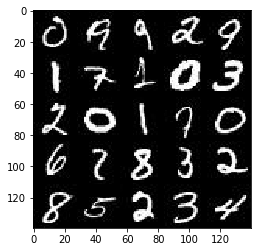

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

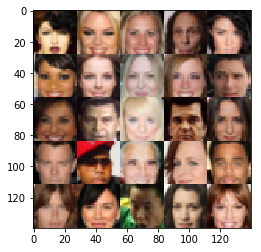

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, 
                                             image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, None, name='lr')
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 or 28x28x1
        layer = tf.layers.conv2d(images, 64, (5, 5), 
                                 strides=(2, 2), 
                                 padding='same',
                                 kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.maximum(alpha*layer, layer)
        # 14x14x64
        
        layer = tf.layers.conv2d(layer, 128, (5, 5), 
                                 strides=(2, 2), 
                                 padding='same',
                                kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(alpha*layer, layer)
        # 7x7x128

        layer = tf.layers.conv2d(layer, 256, (5, 5), 
                                 strides=(2, 2), 
                                 padding='same',
                                 kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(alpha*layer, layer)
        # 4x4x256
        
        layer = tf.reshape(layer, (-1, 4*4*256))
        logits = tf.layers.dense(layer, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # use normal ReLu instead of leaky Relu, as recommended in the original paper
    
    #alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('generator', reuse=not is_train):
        layer = tf.layers.dense(z, 7*7*256, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.reshape(layer, (-1, 7, 7, 256))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        #layer = tf.maximum(alpha*layer, layer)
        # 7x7x256
        
        layer = tf.layers.conv2d_transpose(layer, 128, (5, 5), 
                                           strides=(2, 2), 
                                           padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        #layer = tf.maximum(alpha*layer, layer)
        # 14x14x128
        
        layer = tf.layers.conv2d_transpose(layer, 64, (5, 5), 
                                           strides=(2, 2), 
                                           padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        #layer = tf.maximum(alpha*layer, layer)
        # 28x28x64
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(layer, 
                                            out_channel_dim, 
                                            (5, 5), 
                                            strides=(1, 1), 
                                            padding='same',
                                            kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.9
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train. \
                        AdamOptimizer(learning_rate=learning_rate, beta1=beta1). \
                            minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train. \
                        AdamOptimizer(learning_rate=learning_rate, beta1=beta1). \
                            minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # For statistic print
    steps = 0
    print_every = 25
    show_every = 100
    
    # create inputs, losses and optimizers
    input_real, input_z, lr = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # reshape and re-scale bacth image
                batch_images = batch_images.reshape(batch_size, *data_shape[1:4])
                batch_images = batch_images*2
                
                # noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers (run generator more often than discriminator)
                _ = sess.run(d_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                
                # print losses every 25 steps
                if steps%print_every == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # show generator output everz 100 steps
                if steps%show_every == 0:
                    show_generator_output(sess, 32, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 25... Discriminator Loss: 2.1748... Generator Loss: 0.4572
Epoch 1/2... Step 50... Discriminator Loss: 2.5153... Generator Loss: 0.1533
Epoch 1/2... Step 75... Discriminator Loss: 1.6398... Generator Loss: 0.4564
Epoch 1/2... Step 100... Discriminator Loss: 1.7001... Generator Loss: 0.5774


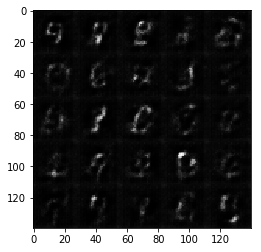

Epoch 1/2... Step 125... Discriminator Loss: 1.4038... Generator Loss: 0.6413
Epoch 1/2... Step 150... Discriminator Loss: 1.5683... Generator Loss: 0.4653
Epoch 1/2... Step 175... Discriminator Loss: 1.4046... Generator Loss: 0.7391
Epoch 1/2... Step 200... Discriminator Loss: 1.5980... Generator Loss: 0.4329


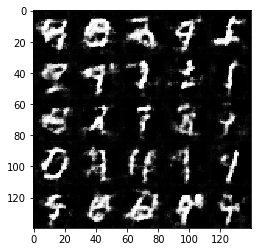

Epoch 1/2... Step 225... Discriminator Loss: 1.5072... Generator Loss: 0.5248
Epoch 1/2... Step 250... Discriminator Loss: 1.5584... Generator Loss: 0.5226
Epoch 1/2... Step 275... Discriminator Loss: 1.5470... Generator Loss: 0.5076
Epoch 1/2... Step 300... Discriminator Loss: 1.5496... Generator Loss: 0.6916


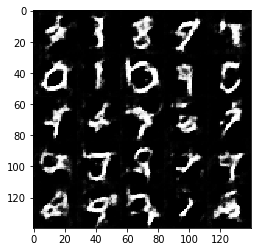

Epoch 1/2... Step 325... Discriminator Loss: 1.3948... Generator Loss: 0.7298
Epoch 1/2... Step 350... Discriminator Loss: 1.5151... Generator Loss: 0.5320
Epoch 1/2... Step 375... Discriminator Loss: 1.5079... Generator Loss: 0.5599
Epoch 1/2... Step 400... Discriminator Loss: 1.4972... Generator Loss: 0.5426


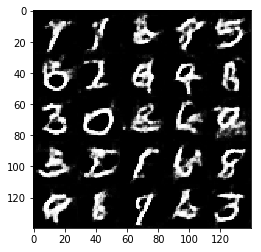

Epoch 1/2... Step 425... Discriminator Loss: 1.4075... Generator Loss: 0.9538
Epoch 1/2... Step 450... Discriminator Loss: 1.4785... Generator Loss: 0.8092
Epoch 1/2... Step 475... Discriminator Loss: 1.4731... Generator Loss: 0.5523
Epoch 1/2... Step 500... Discriminator Loss: 1.4256... Generator Loss: 0.6041


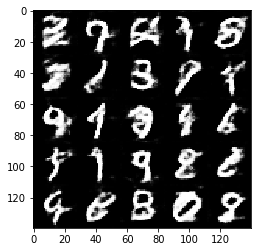

Epoch 1/2... Step 525... Discriminator Loss: 1.3274... Generator Loss: 0.7869
Epoch 1/2... Step 550... Discriminator Loss: 1.4691... Generator Loss: 0.7276
Epoch 1/2... Step 575... Discriminator Loss: 1.5383... Generator Loss: 0.4741
Epoch 1/2... Step 600... Discriminator Loss: 1.4729... Generator Loss: 0.6444


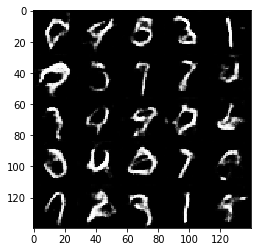

Epoch 1/2... Step 625... Discriminator Loss: 1.6513... Generator Loss: 0.7006
Epoch 1/2... Step 650... Discriminator Loss: 1.5639... Generator Loss: 0.4437
Epoch 1/2... Step 675... Discriminator Loss: 1.4648... Generator Loss: 0.5308
Epoch 1/2... Step 700... Discriminator Loss: 1.4260... Generator Loss: 0.7982


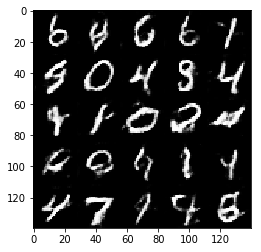

Epoch 1/2... Step 725... Discriminator Loss: 1.5173... Generator Loss: 0.8647
Epoch 1/2... Step 750... Discriminator Loss: 1.5373... Generator Loss: 0.5486
Epoch 1/2... Step 775... Discriminator Loss: 1.5644... Generator Loss: 0.4019
Epoch 1/2... Step 800... Discriminator Loss: 1.3760... Generator Loss: 0.6337


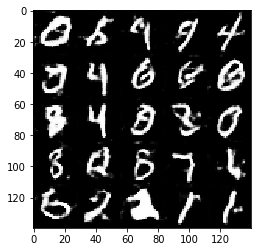

Epoch 1/2... Step 825... Discriminator Loss: 1.5468... Generator Loss: 0.4674
Epoch 1/2... Step 850... Discriminator Loss: 1.6676... Generator Loss: 0.3616
Epoch 1/2... Step 875... Discriminator Loss: 1.3331... Generator Loss: 0.9464
Epoch 1/2... Step 900... Discriminator Loss: 1.6512... Generator Loss: 1.1832


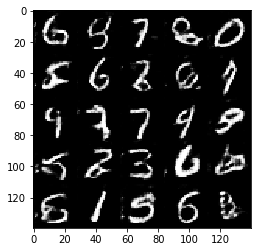

Epoch 1/2... Step 925... Discriminator Loss: 1.6128... Generator Loss: 0.4603
Epoch 2/2... Step 950... Discriminator Loss: 1.4495... Generator Loss: 0.8482
Epoch 2/2... Step 975... Discriminator Loss: 1.5715... Generator Loss: 0.6382
Epoch 2/2... Step 1000... Discriminator Loss: 1.3967... Generator Loss: 0.6602


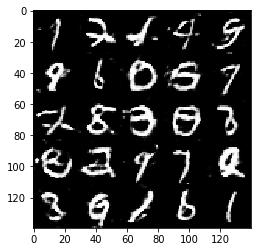

Epoch 2/2... Step 1025... Discriminator Loss: 1.4891... Generator Loss: 0.6313
Epoch 2/2... Step 1050... Discriminator Loss: 1.4357... Generator Loss: 0.6358
Epoch 2/2... Step 1075... Discriminator Loss: 1.4568... Generator Loss: 0.5343
Epoch 2/2... Step 1100... Discriminator Loss: 1.5149... Generator Loss: 0.6015


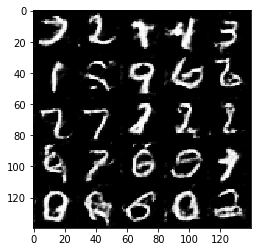

Epoch 2/2... Step 1125... Discriminator Loss: 1.5154... Generator Loss: 0.4749
Epoch 2/2... Step 1150... Discriminator Loss: 1.4375... Generator Loss: 0.5475
Epoch 2/2... Step 1175... Discriminator Loss: 1.3189... Generator Loss: 0.7041
Epoch 2/2... Step 1200... Discriminator Loss: 1.6260... Generator Loss: 0.4171


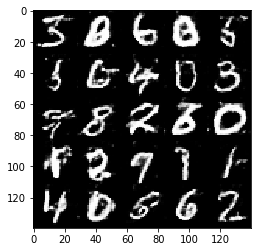

Epoch 2/2... Step 1225... Discriminator Loss: 1.4221... Generator Loss: 0.6349
Epoch 2/2... Step 1250... Discriminator Loss: 1.5717... Generator Loss: 0.4220
Epoch 2/2... Step 1275... Discriminator Loss: 1.3928... Generator Loss: 1.3206
Epoch 2/2... Step 1300... Discriminator Loss: 1.4050... Generator Loss: 0.7094


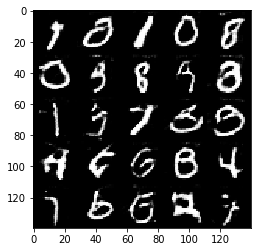

Epoch 2/2... Step 1325... Discriminator Loss: 1.4695... Generator Loss: 0.9043
Epoch 2/2... Step 1350... Discriminator Loss: 1.4158... Generator Loss: 0.8443
Epoch 2/2... Step 1375... Discriminator Loss: 1.5494... Generator Loss: 0.5469
Epoch 2/2... Step 1400... Discriminator Loss: 1.2532... Generator Loss: 0.6689


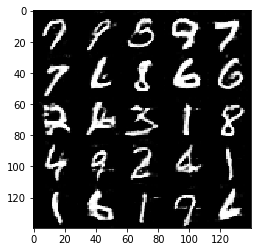

Epoch 2/2... Step 1425... Discriminator Loss: 1.4931... Generator Loss: 0.5471
Epoch 2/2... Step 1450... Discriminator Loss: 1.3805... Generator Loss: 0.6306
Epoch 2/2... Step 1475... Discriminator Loss: 1.5541... Generator Loss: 0.8606
Epoch 2/2... Step 1500... Discriminator Loss: 1.5122... Generator Loss: 0.5347


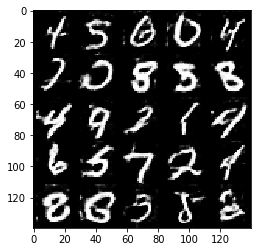

Epoch 2/2... Step 1525... Discriminator Loss: 1.4144... Generator Loss: 0.6438
Epoch 2/2... Step 1550... Discriminator Loss: 1.4860... Generator Loss: 0.5056
Epoch 2/2... Step 1575... Discriminator Loss: 1.5052... Generator Loss: 1.3564
Epoch 2/2... Step 1600... Discriminator Loss: 1.3956... Generator Loss: 0.8634


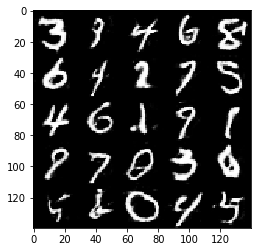

Epoch 2/2... Step 1625... Discriminator Loss: 1.4944... Generator Loss: 0.5797
Epoch 2/2... Step 1650... Discriminator Loss: 1.4440... Generator Loss: 0.6440
Epoch 2/2... Step 1675... Discriminator Loss: 1.3884... Generator Loss: 0.6663
Epoch 2/2... Step 1700... Discriminator Loss: 1.4160... Generator Loss: 0.5596


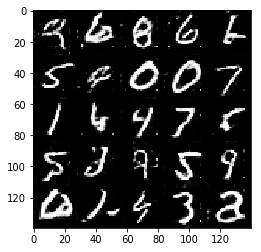

Epoch 2/2... Step 1725... Discriminator Loss: 1.4416... Generator Loss: 0.7400
Epoch 2/2... Step 1750... Discriminator Loss: 1.2696... Generator Loss: 0.8710
Epoch 2/2... Step 1775... Discriminator Loss: 1.3471... Generator Loss: 0.7260
Epoch 2/2... Step 1800... Discriminator Loss: 1.2920... Generator Loss: 0.6816


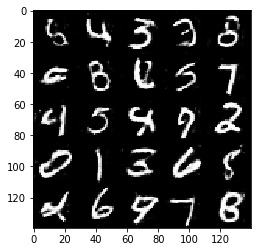

Epoch 2/2... Step 1825... Discriminator Loss: 1.4049... Generator Loss: 1.2579
Epoch 2/2... Step 1850... Discriminator Loss: 1.2571... Generator Loss: 0.8758


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
tf.reset_default_graph()

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Step 25... Discriminator Loss: 2.4391... Generator Loss: 0.7025
Epoch 1/2... Step 50... Discriminator Loss: 2.1238... Generator Loss: 0.5520
Epoch 1/2... Step 75... Discriminator Loss: 1.7104... Generator Loss: 0.5802
Epoch 1/2... Step 100... Discriminator Loss: 1.6431... Generator Loss: 0.6178


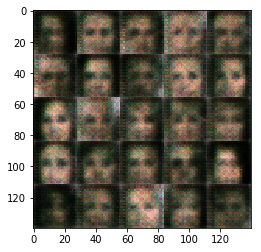

Epoch 1/2... Step 125... Discriminator Loss: 1.6455... Generator Loss: 0.5840
Epoch 1/2... Step 150... Discriminator Loss: 1.4798... Generator Loss: 0.7146
Epoch 1/2... Step 175... Discriminator Loss: 1.4693... Generator Loss: 0.6589
Epoch 1/2... Step 200... Discriminator Loss: 1.4085... Generator Loss: 0.6723


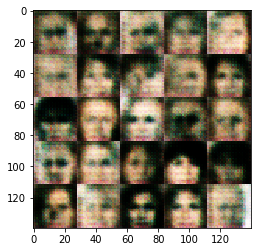

Epoch 1/2... Step 225... Discriminator Loss: 1.5845... Generator Loss: 0.7105
Epoch 1/2... Step 250... Discriminator Loss: 1.6597... Generator Loss: 0.5641
Epoch 1/2... Step 275... Discriminator Loss: 1.7316... Generator Loss: 0.5875
Epoch 1/2... Step 300... Discriminator Loss: 1.5081... Generator Loss: 0.7356


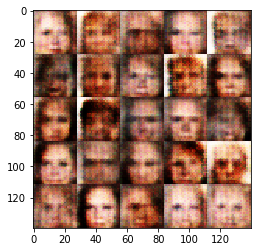

Epoch 1/2... Step 325... Discriminator Loss: 1.5412... Generator Loss: 0.6832
Epoch 1/2... Step 350... Discriminator Loss: 1.3959... Generator Loss: 0.7458
Epoch 1/2... Step 375... Discriminator Loss: 1.5291... Generator Loss: 0.6327
Epoch 1/2... Step 400... Discriminator Loss: 1.4460... Generator Loss: 0.7748


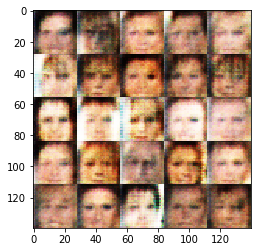

Epoch 1/2... Step 425... Discriminator Loss: 1.4594... Generator Loss: 0.7546
Epoch 1/2... Step 450... Discriminator Loss: 1.5175... Generator Loss: 0.6518
Epoch 1/2... Step 475... Discriminator Loss: 1.5270... Generator Loss: 0.6490
Epoch 1/2... Step 500... Discriminator Loss: 1.4653... Generator Loss: 0.7583


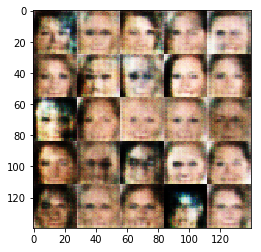

Epoch 1/2... Step 525... Discriminator Loss: 1.4777... Generator Loss: 0.7604
Epoch 1/2... Step 550... Discriminator Loss: 1.5350... Generator Loss: 0.6954
Epoch 1/2... Step 575... Discriminator Loss: 1.4079... Generator Loss: 0.8475
Epoch 1/2... Step 600... Discriminator Loss: 1.5056... Generator Loss: 0.7278


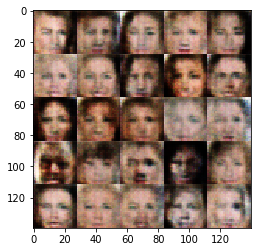

Epoch 1/2... Step 625... Discriminator Loss: 1.4472... Generator Loss: 0.7452
Epoch 1/2... Step 650... Discriminator Loss: 1.3868... Generator Loss: 0.7623
Epoch 1/2... Step 675... Discriminator Loss: 1.4158... Generator Loss: 0.7344
Epoch 1/2... Step 700... Discriminator Loss: 1.4320... Generator Loss: 0.7772


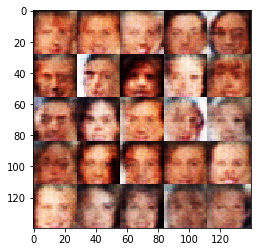

Epoch 1/2... Step 725... Discriminator Loss: 1.3994... Generator Loss: 0.7843
Epoch 1/2... Step 750... Discriminator Loss: 1.5002... Generator Loss: 0.7343
Epoch 1/2... Step 775... Discriminator Loss: 1.4176... Generator Loss: 0.6982
Epoch 1/2... Step 800... Discriminator Loss: 1.4454... Generator Loss: 0.8155


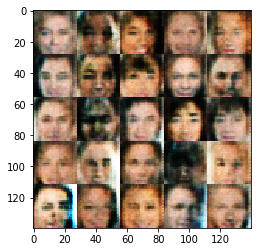

Epoch 1/2... Step 825... Discriminator Loss: 1.4098... Generator Loss: 0.7886
Epoch 1/2... Step 850... Discriminator Loss: 1.4159... Generator Loss: 0.7943
Epoch 1/2... Step 875... Discriminator Loss: 1.4882... Generator Loss: 0.7190
Epoch 1/2... Step 900... Discriminator Loss: 1.4705... Generator Loss: 0.6830


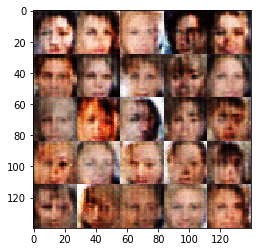

Epoch 1/2... Step 925... Discriminator Loss: 1.4265... Generator Loss: 0.7748
Epoch 1/2... Step 950... Discriminator Loss: 1.4731... Generator Loss: 0.7161
Epoch 1/2... Step 975... Discriminator Loss: 1.3806... Generator Loss: 0.7836
Epoch 1/2... Step 1000... Discriminator Loss: 1.5037... Generator Loss: 0.6474


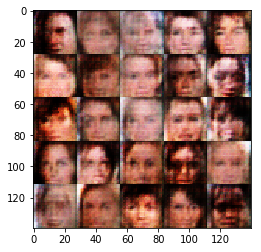

Epoch 1/2... Step 1025... Discriminator Loss: 1.4957... Generator Loss: 0.7821
Epoch 1/2... Step 1050... Discriminator Loss: 1.4626... Generator Loss: 0.8328
Epoch 1/2... Step 1075... Discriminator Loss: 1.4461... Generator Loss: 0.6918
Epoch 1/2... Step 1100... Discriminator Loss: 1.4634... Generator Loss: 0.7122


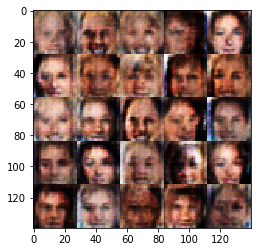

Epoch 1/2... Step 1125... Discriminator Loss: 1.3913... Generator Loss: 0.7932
Epoch 1/2... Step 1150... Discriminator Loss: 1.4149... Generator Loss: 0.7947
Epoch 1/2... Step 1175... Discriminator Loss: 1.4216... Generator Loss: 0.8290
Epoch 1/2... Step 1200... Discriminator Loss: 1.4161... Generator Loss: 0.7945


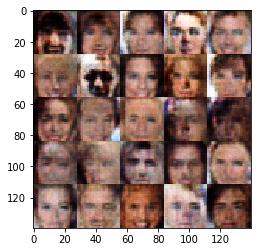

Epoch 1/2... Step 1225... Discriminator Loss: 1.4683... Generator Loss: 0.6929
Epoch 1/2... Step 1250... Discriminator Loss: 1.4829... Generator Loss: 0.7700
Epoch 1/2... Step 1275... Discriminator Loss: 1.4354... Generator Loss: 0.7917
Epoch 1/2... Step 1300... Discriminator Loss: 1.4716... Generator Loss: 0.7566


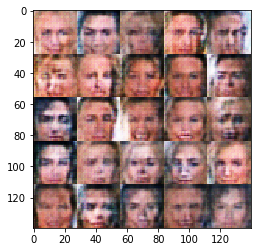

Epoch 1/2... Step 1325... Discriminator Loss: 1.4834... Generator Loss: 0.6571
Epoch 1/2... Step 1350... Discriminator Loss: 1.3819... Generator Loss: 0.8154
Epoch 1/2... Step 1375... Discriminator Loss: 1.4575... Generator Loss: 0.8040
Epoch 1/2... Step 1400... Discriminator Loss: 1.4466... Generator Loss: 0.7854


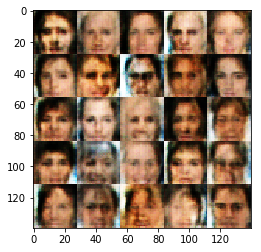

Epoch 1/2... Step 1425... Discriminator Loss: 1.4791... Generator Loss: 0.7377
Epoch 1/2... Step 1450... Discriminator Loss: 1.4155... Generator Loss: 0.7736
Epoch 1/2... Step 1475... Discriminator Loss: 1.4678... Generator Loss: 0.7812
Epoch 1/2... Step 1500... Discriminator Loss: 1.4265... Generator Loss: 0.7346


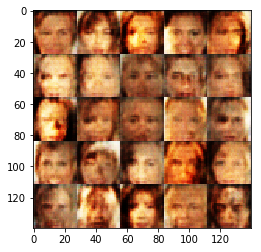

Epoch 1/2... Step 1525... Discriminator Loss: 1.4218... Generator Loss: 0.7640
Epoch 1/2... Step 1550... Discriminator Loss: 1.4386... Generator Loss: 0.7954
Epoch 1/2... Step 1575... Discriminator Loss: 1.4653... Generator Loss: 0.7617
Epoch 1/2... Step 1600... Discriminator Loss: 1.4363... Generator Loss: 0.7971


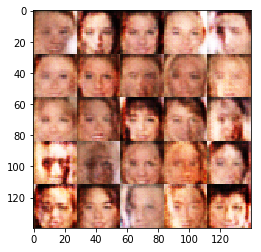

Epoch 1/2... Step 1625... Discriminator Loss: 1.4605... Generator Loss: 0.7493
Epoch 1/2... Step 1650... Discriminator Loss: 1.3725... Generator Loss: 0.8300
Epoch 1/2... Step 1675... Discriminator Loss: 1.4207... Generator Loss: 0.7652
Epoch 1/2... Step 1700... Discriminator Loss: 1.4314... Generator Loss: 0.7114


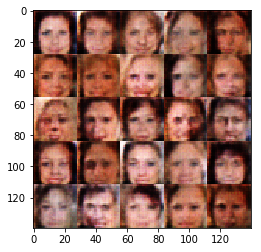

Epoch 1/2... Step 1725... Discriminator Loss: 1.4104... Generator Loss: 0.8020
Epoch 1/2... Step 1750... Discriminator Loss: 1.4148... Generator Loss: 0.7143
Epoch 1/2... Step 1775... Discriminator Loss: 1.4111... Generator Loss: 0.7541
Epoch 1/2... Step 1800... Discriminator Loss: 1.4318... Generator Loss: 0.7292


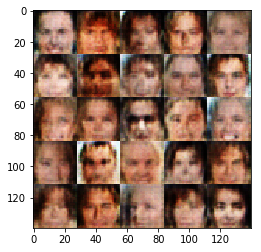

Epoch 1/2... Step 1825... Discriminator Loss: 1.3884... Generator Loss: 0.7240
Epoch 1/2... Step 1850... Discriminator Loss: 1.5566... Generator Loss: 0.7009
Epoch 1/2... Step 1875... Discriminator Loss: 1.4402... Generator Loss: 0.7427
Epoch 1/2... Step 1900... Discriminator Loss: 1.4203... Generator Loss: 0.7036


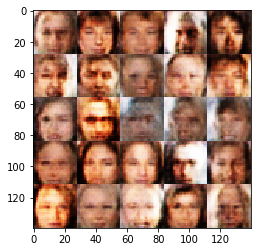

Epoch 1/2... Step 1925... Discriminator Loss: 1.4197... Generator Loss: 0.8113
Epoch 1/2... Step 1950... Discriminator Loss: 1.3929... Generator Loss: 0.8055
Epoch 1/2... Step 1975... Discriminator Loss: 1.4342... Generator Loss: 0.7608
Epoch 1/2... Step 2000... Discriminator Loss: 1.4130... Generator Loss: 0.7888


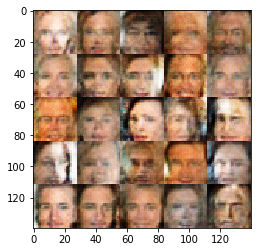

Epoch 1/2... Step 2025... Discriminator Loss: 1.4325... Generator Loss: 0.7503
Epoch 1/2... Step 2050... Discriminator Loss: 1.3763... Generator Loss: 0.7852
Epoch 1/2... Step 2075... Discriminator Loss: 1.4096... Generator Loss: 0.7441
Epoch 1/2... Step 2100... Discriminator Loss: 1.3952... Generator Loss: 0.8031


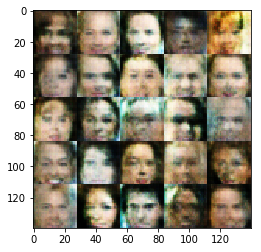

Epoch 1/2... Step 2125... Discriminator Loss: 1.4120... Generator Loss: 0.8048
Epoch 1/2... Step 2150... Discriminator Loss: 1.4434... Generator Loss: 0.7435
Epoch 1/2... Step 2175... Discriminator Loss: 1.4341... Generator Loss: 0.7410
Epoch 1/2... Step 2200... Discriminator Loss: 1.4907... Generator Loss: 0.7167


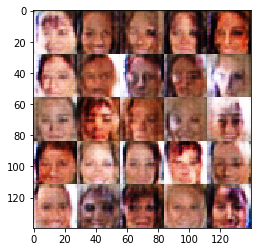

Epoch 1/2... Step 2225... Discriminator Loss: 1.4184... Generator Loss: 0.7840
Epoch 1/2... Step 2250... Discriminator Loss: 1.4040... Generator Loss: 0.7442
Epoch 1/2... Step 2275... Discriminator Loss: 1.4101... Generator Loss: 0.7550
Epoch 1/2... Step 2300... Discriminator Loss: 1.4062... Generator Loss: 0.8711


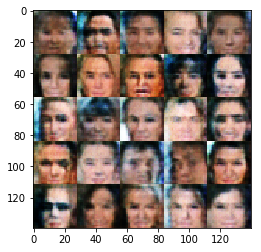

Epoch 1/2... Step 2325... Discriminator Loss: 1.4370... Generator Loss: 0.8181
Epoch 1/2... Step 2350... Discriminator Loss: 1.4151... Generator Loss: 0.6868
Epoch 1/2... Step 2375... Discriminator Loss: 1.4470... Generator Loss: 0.7389
Epoch 1/2... Step 2400... Discriminator Loss: 1.4323... Generator Loss: 0.7502


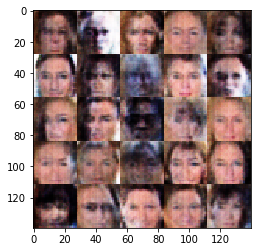

Epoch 1/2... Step 2425... Discriminator Loss: 1.4342... Generator Loss: 0.7554
Epoch 1/2... Step 2450... Discriminator Loss: 1.4536... Generator Loss: 0.7764
Epoch 1/2... Step 2475... Discriminator Loss: 1.4273... Generator Loss: 0.7026
Epoch 1/2... Step 2500... Discriminator Loss: 1.4075... Generator Loss: 0.7822


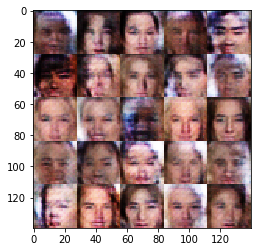

Epoch 1/2... Step 2525... Discriminator Loss: 1.3944... Generator Loss: 0.7821
Epoch 1/2... Step 2550... Discriminator Loss: 1.3882... Generator Loss: 0.7330
Epoch 1/2... Step 2575... Discriminator Loss: 1.4304... Generator Loss: 0.8002
Epoch 1/2... Step 2600... Discriminator Loss: 1.3820... Generator Loss: 0.7741


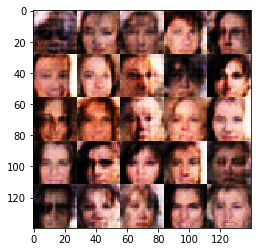

Epoch 1/2... Step 2625... Discriminator Loss: 1.4520... Generator Loss: 0.7338
Epoch 1/2... Step 2650... Discriminator Loss: 1.4310... Generator Loss: 0.7287
Epoch 1/2... Step 2675... Discriminator Loss: 1.4247... Generator Loss: 0.8157
Epoch 1/2... Step 2700... Discriminator Loss: 1.4118... Generator Loss: 0.6980


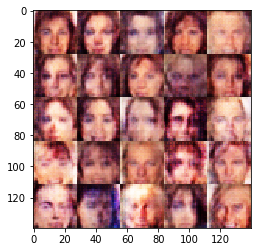

Epoch 1/2... Step 2725... Discriminator Loss: 1.4196... Generator Loss: 0.7371
Epoch 1/2... Step 2750... Discriminator Loss: 1.4225... Generator Loss: 0.7801
Epoch 1/2... Step 2775... Discriminator Loss: 1.4348... Generator Loss: 0.7150
Epoch 1/2... Step 2800... Discriminator Loss: 1.4174... Generator Loss: 0.7592


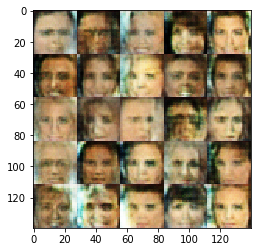

Epoch 1/2... Step 2825... Discriminator Loss: 1.4777... Generator Loss: 0.7481
Epoch 1/2... Step 2850... Discriminator Loss: 1.4397... Generator Loss: 0.7588
Epoch 1/2... Step 2875... Discriminator Loss: 1.3876... Generator Loss: 0.8249
Epoch 1/2... Step 2900... Discriminator Loss: 1.4122... Generator Loss: 0.7270


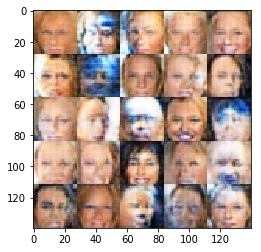

Epoch 1/2... Step 2925... Discriminator Loss: 1.4250... Generator Loss: 0.7123
Epoch 1/2... Step 2950... Discriminator Loss: 1.4213... Generator Loss: 0.7677
Epoch 1/2... Step 2975... Discriminator Loss: 1.4051... Generator Loss: 0.7850
Epoch 1/2... Step 3000... Discriminator Loss: 1.4278... Generator Loss: 0.7286


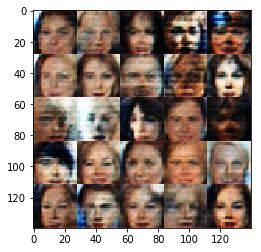

Epoch 1/2... Step 3025... Discriminator Loss: 1.4181... Generator Loss: 0.7839
Epoch 1/2... Step 3050... Discriminator Loss: 1.4135... Generator Loss: 0.7861
Epoch 1/2... Step 3075... Discriminator Loss: 1.4321... Generator Loss: 0.7582
Epoch 1/2... Step 3100... Discriminator Loss: 1.3950... Generator Loss: 0.7519


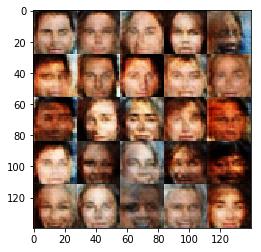

Epoch 1/2... Step 3125... Discriminator Loss: 1.4073... Generator Loss: 0.7183
Epoch 1/2... Step 3150... Discriminator Loss: 1.3915... Generator Loss: 0.7700
Epoch 2/2... Step 3175... Discriminator Loss: 1.4857... Generator Loss: 0.6254
Epoch 2/2... Step 3200... Discriminator Loss: 1.4199... Generator Loss: 0.7535


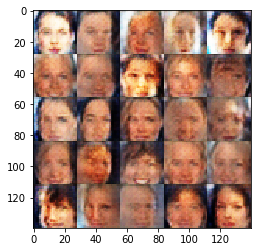

Epoch 2/2... Step 3225... Discriminator Loss: 1.4045... Generator Loss: 0.7623
Epoch 2/2... Step 3250... Discriminator Loss: 1.4099... Generator Loss: 0.7748
Epoch 2/2... Step 3275... Discriminator Loss: 1.3811... Generator Loss: 0.7788
Epoch 2/2... Step 3300... Discriminator Loss: 1.4057... Generator Loss: 0.8092


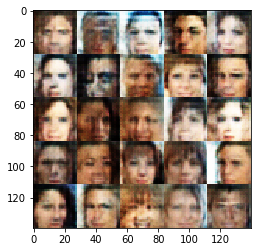

Epoch 2/2... Step 3325... Discriminator Loss: 1.4566... Generator Loss: 0.7433
Epoch 2/2... Step 3350... Discriminator Loss: 1.4264... Generator Loss: 0.8151
Epoch 2/2... Step 3375... Discriminator Loss: 1.3955... Generator Loss: 0.7891
Epoch 2/2... Step 3400... Discriminator Loss: 1.3955... Generator Loss: 0.7371


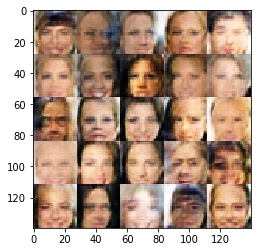

Epoch 2/2... Step 3425... Discriminator Loss: 1.4025... Generator Loss: 0.7794
Epoch 2/2... Step 3450... Discriminator Loss: 1.3893... Generator Loss: 0.8199
Epoch 2/2... Step 3475... Discriminator Loss: 1.4153... Generator Loss: 0.8156
Epoch 2/2... Step 3500... Discriminator Loss: 1.3966... Generator Loss: 0.7553


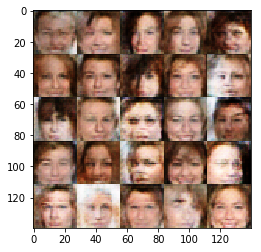

Epoch 2/2... Step 3525... Discriminator Loss: 1.4056... Generator Loss: 0.8285
Epoch 2/2... Step 3550... Discriminator Loss: 1.4479... Generator Loss: 0.7898
Epoch 2/2... Step 3575... Discriminator Loss: 1.4606... Generator Loss: 0.6742
Epoch 2/2... Step 3600... Discriminator Loss: 1.4016... Generator Loss: 0.7259


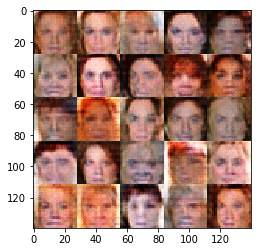

Epoch 2/2... Step 3625... Discriminator Loss: 1.4027... Generator Loss: 0.7824
Epoch 2/2... Step 3650... Discriminator Loss: 1.4042... Generator Loss: 0.8363
Epoch 2/2... Step 3675... Discriminator Loss: 1.4115... Generator Loss: 0.8017
Epoch 2/2... Step 3700... Discriminator Loss: 1.4140... Generator Loss: 0.8404


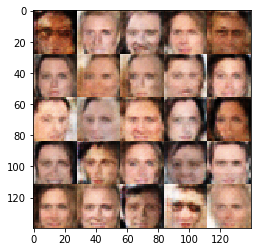

Epoch 2/2... Step 3725... Discriminator Loss: 1.3638... Generator Loss: 0.7966
Epoch 2/2... Step 3750... Discriminator Loss: 1.4192... Generator Loss: 0.8651
Epoch 2/2... Step 3775... Discriminator Loss: 1.3924... Generator Loss: 0.8189
Epoch 2/2... Step 3800... Discriminator Loss: 1.4156... Generator Loss: 0.7383


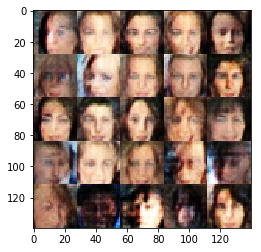

Epoch 2/2... Step 3825... Discriminator Loss: 1.3973... Generator Loss: 0.7642
Epoch 2/2... Step 3850... Discriminator Loss: 1.4325... Generator Loss: 0.6925
Epoch 2/2... Step 3875... Discriminator Loss: 1.4011... Generator Loss: 0.8009
Epoch 2/2... Step 3900... Discriminator Loss: 1.4336... Generator Loss: 0.7152


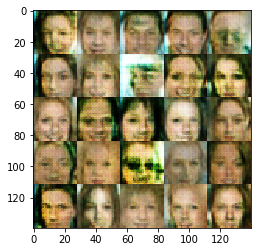

Epoch 2/2... Step 3925... Discriminator Loss: 1.3827... Generator Loss: 0.7443
Epoch 2/2... Step 3950... Discriminator Loss: 1.4348... Generator Loss: 0.7042
Epoch 2/2... Step 3975... Discriminator Loss: 1.4376... Generator Loss: 0.7220
Epoch 2/2... Step 4000... Discriminator Loss: 1.4008... Generator Loss: 0.8062


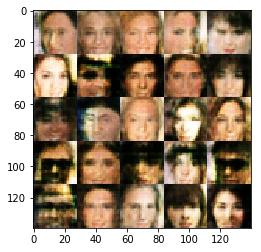

Epoch 2/2... Step 4025... Discriminator Loss: 1.4198... Generator Loss: 0.7498
Epoch 2/2... Step 4050... Discriminator Loss: 1.4374... Generator Loss: 0.6882
Epoch 2/2... Step 4075... Discriminator Loss: 1.4019... Generator Loss: 0.7693
Epoch 2/2... Step 4100... Discriminator Loss: 1.4005... Generator Loss: 0.7565


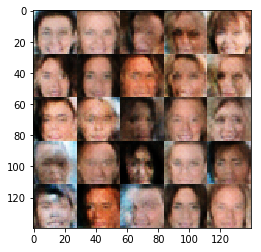

Epoch 2/2... Step 4125... Discriminator Loss: 1.4162... Generator Loss: 0.7333
Epoch 2/2... Step 4150... Discriminator Loss: 1.4074... Generator Loss: 0.7868
Epoch 2/2... Step 4175... Discriminator Loss: 1.4082... Generator Loss: 0.7927
Epoch 2/2... Step 4200... Discriminator Loss: 1.3914... Generator Loss: 0.8034


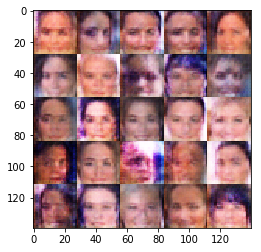

Epoch 2/2... Step 4225... Discriminator Loss: 1.3871... Generator Loss: 0.8319
Epoch 2/2... Step 4250... Discriminator Loss: 1.4083... Generator Loss: 0.7621
Epoch 2/2... Step 4275... Discriminator Loss: 1.3881... Generator Loss: 0.7848
Epoch 2/2... Step 4300... Discriminator Loss: 1.4169... Generator Loss: 0.7510


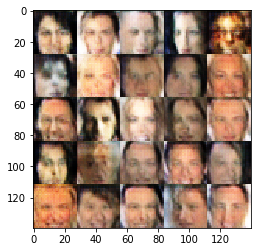

Epoch 2/2... Step 4325... Discriminator Loss: 1.4200... Generator Loss: 0.7697
Epoch 2/2... Step 4350... Discriminator Loss: 1.4045... Generator Loss: 0.7878
Epoch 2/2... Step 4375... Discriminator Loss: 1.3990... Generator Loss: 0.6662
Epoch 2/2... Step 4400... Discriminator Loss: 1.3880... Generator Loss: 0.7930


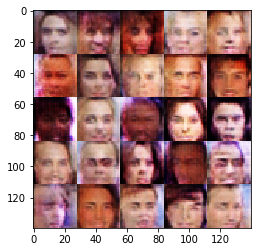

Epoch 2/2... Step 4425... Discriminator Loss: 1.4139... Generator Loss: 0.7853
Epoch 2/2... Step 4450... Discriminator Loss: 1.3879... Generator Loss: 0.7542
Epoch 2/2... Step 4475... Discriminator Loss: 1.4219... Generator Loss: 0.6951
Epoch 2/2... Step 4500... Discriminator Loss: 1.4164... Generator Loss: 0.8130


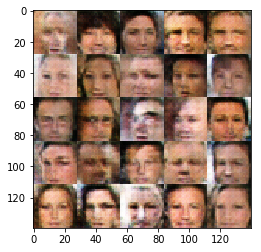

Epoch 2/2... Step 4525... Discriminator Loss: 1.4176... Generator Loss: 0.7521
Epoch 2/2... Step 4550... Discriminator Loss: 1.3961... Generator Loss: 0.8176
Epoch 2/2... Step 4575... Discriminator Loss: 1.3974... Generator Loss: 0.8054
Epoch 2/2... Step 4600... Discriminator Loss: 1.4066... Generator Loss: 0.7279


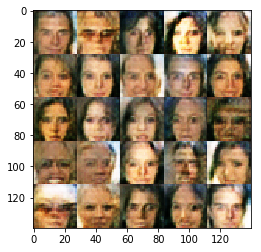

Epoch 2/2... Step 4625... Discriminator Loss: 1.3967... Generator Loss: 0.7530
Epoch 2/2... Step 4650... Discriminator Loss: 1.3873... Generator Loss: 0.7920
Epoch 2/2... Step 4675... Discriminator Loss: 1.3996... Generator Loss: 0.7921
Epoch 2/2... Step 4700... Discriminator Loss: 1.4029... Generator Loss: 0.7739


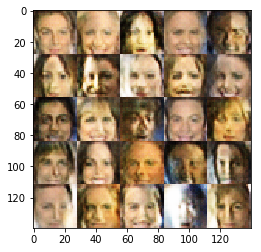

Epoch 2/2... Step 4725... Discriminator Loss: 1.3989... Generator Loss: 0.8147
Epoch 2/2... Step 4750... Discriminator Loss: 1.4028... Generator Loss: 0.7790
Epoch 2/2... Step 4775... Discriminator Loss: 1.4025... Generator Loss: 0.8553
Epoch 2/2... Step 4800... Discriminator Loss: 1.4257... Generator Loss: 0.8378


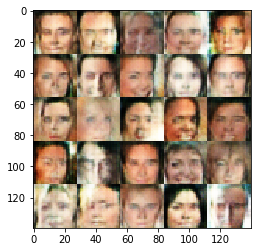

Epoch 2/2... Step 4825... Discriminator Loss: 1.4150... Generator Loss: 0.7024
Epoch 2/2... Step 4850... Discriminator Loss: 1.4079... Generator Loss: 0.8337
Epoch 2/2... Step 4875... Discriminator Loss: 1.4159... Generator Loss: 0.7596
Epoch 2/2... Step 4900... Discriminator Loss: 1.3987... Generator Loss: 0.8001


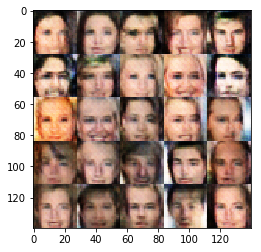

Epoch 2/2... Step 4925... Discriminator Loss: 1.3938... Generator Loss: 0.7602
Epoch 2/2... Step 4950... Discriminator Loss: 1.3948... Generator Loss: 0.7834
Epoch 2/2... Step 4975... Discriminator Loss: 1.4132... Generator Loss: 0.7616
Epoch 2/2... Step 5000... Discriminator Loss: 1.4086... Generator Loss: 0.7673


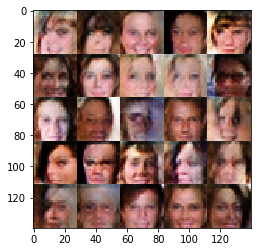

Epoch 2/2... Step 5025... Discriminator Loss: 1.3931... Generator Loss: 0.7989
Epoch 2/2... Step 5050... Discriminator Loss: 1.3868... Generator Loss: 0.7704
Epoch 2/2... Step 5075... Discriminator Loss: 1.3976... Generator Loss: 0.7331
Epoch 2/2... Step 5100... Discriminator Loss: 1.4261... Generator Loss: 0.8781


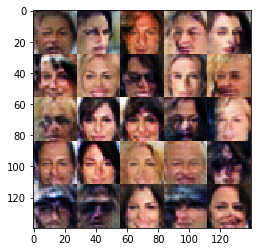

Epoch 2/2... Step 5125... Discriminator Loss: 1.3803... Generator Loss: 0.7470
Epoch 2/2... Step 5150... Discriminator Loss: 1.4004... Generator Loss: 0.8448
Epoch 2/2... Step 5175... Discriminator Loss: 1.3901... Generator Loss: 0.7551
Epoch 2/2... Step 5200... Discriminator Loss: 1.4005... Generator Loss: 0.7950


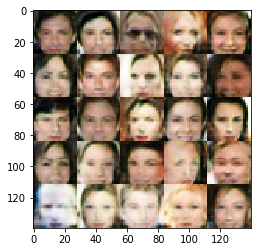

Epoch 2/2... Step 5225... Discriminator Loss: 1.3820... Generator Loss: 0.8449
Epoch 2/2... Step 5250... Discriminator Loss: 1.3934... Generator Loss: 0.7350
Epoch 2/2... Step 5275... Discriminator Loss: 1.4094... Generator Loss: 0.7891
Epoch 2/2... Step 5300... Discriminator Loss: 1.4022... Generator Loss: 0.8305


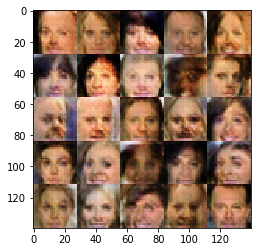

Epoch 2/2... Step 5325... Discriminator Loss: 1.3986... Generator Loss: 0.7875
Epoch 2/2... Step 5350... Discriminator Loss: 1.4050... Generator Loss: 0.7133
Epoch 2/2... Step 5375... Discriminator Loss: 1.3884... Generator Loss: 0.7585
Epoch 2/2... Step 5400... Discriminator Loss: 1.3937... Generator Loss: 0.8316


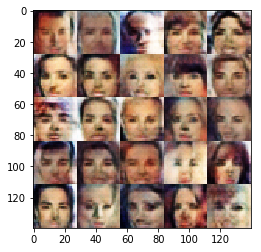

Epoch 2/2... Step 5425... Discriminator Loss: 1.3960... Generator Loss: 0.7691
Epoch 2/2... Step 5450... Discriminator Loss: 1.3935... Generator Loss: 0.7437
Epoch 2/2... Step 5475... Discriminator Loss: 1.4070... Generator Loss: 0.8349
Epoch 2/2... Step 5500... Discriminator Loss: 1.3803... Generator Loss: 0.8819


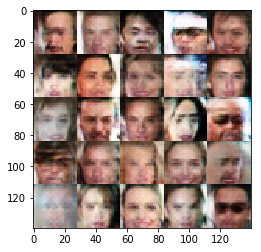

Epoch 2/2... Step 5525... Discriminator Loss: 1.4006... Generator Loss: 0.7466
Epoch 2/2... Step 5550... Discriminator Loss: 1.3974... Generator Loss: 0.7838
Epoch 2/2... Step 5575... Discriminator Loss: 1.3935... Generator Loss: 0.8364
Epoch 2/2... Step 5600... Discriminator Loss: 1.4031... Generator Loss: 0.7730


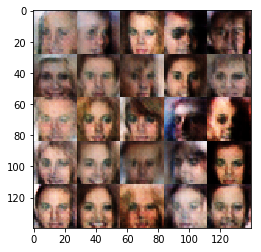

Epoch 2/2... Step 5625... Discriminator Loss: 1.3983... Generator Loss: 0.7437
Epoch 2/2... Step 5650... Discriminator Loss: 1.3792... Generator Loss: 0.8212
Epoch 2/2... Step 5675... Discriminator Loss: 1.3873... Generator Loss: 0.7533
Epoch 2/2... Step 5700... Discriminator Loss: 1.3860... Generator Loss: 0.7771


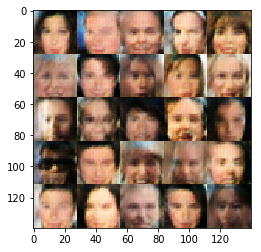

Epoch 2/2... Step 5725... Discriminator Loss: 1.3997... Generator Loss: 0.7849
Epoch 2/2... Step 5750... Discriminator Loss: 1.4022... Generator Loss: 0.8403
Epoch 2/2... Step 5775... Discriminator Loss: 1.3876... Generator Loss: 0.7950
Epoch 2/2... Step 5800... Discriminator Loss: 1.3831... Generator Loss: 0.7851


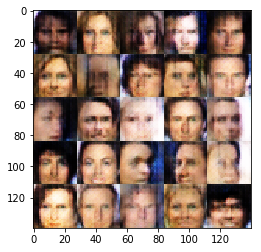

Epoch 2/2... Step 5825... Discriminator Loss: 1.3919... Generator Loss: 0.7815
Epoch 2/2... Step 5850... Discriminator Loss: 1.3914... Generator Loss: 0.7911
Epoch 2/2... Step 5875... Discriminator Loss: 1.3870... Generator Loss: 0.7666
Epoch 2/2... Step 5900... Discriminator Loss: 1.3937... Generator Loss: 0.7754


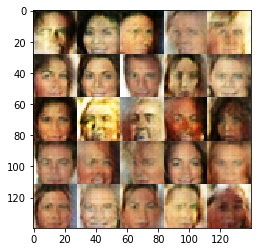

Epoch 2/2... Step 5925... Discriminator Loss: 1.4099... Generator Loss: 0.8028
Epoch 2/2... Step 5950... Discriminator Loss: 1.4162... Generator Loss: 0.8030
Epoch 2/2... Step 5975... Discriminator Loss: 1.4070... Generator Loss: 0.7595
Epoch 2/2... Step 6000... Discriminator Loss: 1.3916... Generator Loss: 0.7729


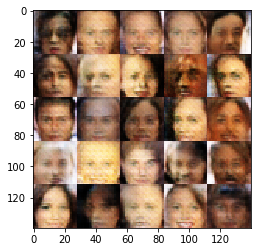

Epoch 2/2... Step 6025... Discriminator Loss: 1.3950... Generator Loss: 0.8061
Epoch 2/2... Step 6050... Discriminator Loss: 1.4035... Generator Loss: 0.7379
Epoch 2/2... Step 6075... Discriminator Loss: 1.3971... Generator Loss: 0.6963
Epoch 2/2... Step 6100... Discriminator Loss: 1.3924... Generator Loss: 0.7427


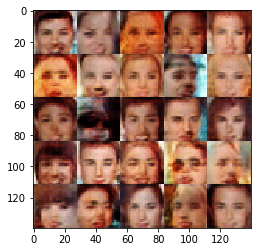

Epoch 2/2... Step 6125... Discriminator Loss: 1.4094... Generator Loss: 0.8525
Epoch 2/2... Step 6150... Discriminator Loss: 1.3982... Generator Loss: 0.7588
Epoch 2/2... Step 6175... Discriminator Loss: 1.3825... Generator Loss: 0.7350
Epoch 2/2... Step 6200... Discriminator Loss: 1.3837... Generator Loss: 0.7794


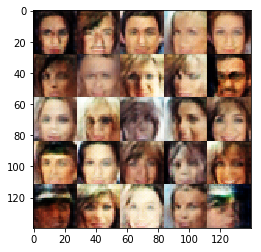

Epoch 2/2... Step 6225... Discriminator Loss: 1.3930... Generator Loss: 0.7864
Epoch 2/2... Step 6250... Discriminator Loss: 1.3870... Generator Loss: 0.7860
Epoch 2/2... Step 6275... Discriminator Loss: 1.3861... Generator Loss: 0.8005
Epoch 2/2... Step 6300... Discriminator Loss: 1.4013... Generator Loss: 0.8615


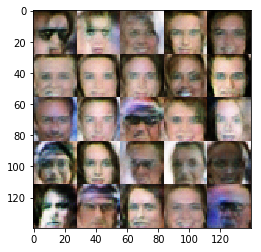

Epoch 2/2... Step 6325... Discriminator Loss: 1.4051... Generator Loss: 0.7311


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
tf.reset_default_graph()

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.